# CS933 Image and Video Analysis -- Lab 2

## Department of Computer Science, University of Warwick
## Oct, 2023

## Aims:

The aims of this lab are to

+ learn about image interpolation (upsampling) using nearest-neighbour and bilinear methods
+ binarise an image with a threshold
+ work out how to do connected component labelling
+ estimate centroids and principal axes of image components
+ encode binary images objects as chain codes and run-lengths
+ calculate distance transforms and skeletons 


## Interpolation

The simplest form of interpolation is linear interpolation.

Given values of some scalar function $ f[i] $ at discrete sample points $ i $, if we want to calculate 
    a linear estimate of values at some point $ x $ given $ i \leq x < i+1 $, we can use the formula:
        
$
    a = floor(x)\\
    b = a + 1\\
    dx = x - a\\
    f[x] = f[a] + dx . (f[b]-f[a])
$

In Python, we can write this as:
~~~~
    def interp(f, x):
    
        a = int(np.floor(x))
        b = a + 1
        dx = x - a
        return f[a] + dx * (f[b]-f[a])
~~~~

In [1]:
# import statements

from typing import Final

import matplotlib.pyplot as plt  # this is for plotting (showing) images
import numpy as np  # this imports the numerical and array library
from PIL import Image  # this contains the image class and methods from PIL library


class UtilityAgent:
    __data_dir: Final[str]

    def __init__(self, *, data_dir: str):
        self.__data_dir = data_dir

    def get_img_located_at(
            self,
            location_of_image: str,
            /,
            *,
            channel_mode: str | None = None,
    ) -> np.ndarray:
        """
        Get the image named `name_of_image` from the data directory.
        """
        img = Image.open(f"{self.__data_dir}/{location_of_image}")

        if channel_mode is not None:
            img = img.convert(channel_mode)

        return np.asarray(img)


agent = UtilityAgent(data_dir="../data")

In [2]:
def linear_interpolate_of(x_: np.number, /, *, func: np.ndarray) -> np.float64:
    """
    Linear interpolation of a function func at x_
    Args:
        x_: x value to interpolate at
        func: function to interpolate
    Returns:
        interpolated value
    """
    length_of_func = len(func)

    i_ = int(np.floor(x_))
    if i_ < 0:
        raise ValueError(f"x_: '{x_}' is out of range of func, i_ is smaller than 0")

    i_plus_1 = i_ + 1
    if i_plus_1 >= length_of_func:
        raise ValueError(f"x_: '{x_}' is out of range of func, i_plus_1 is out of range")

    dx = x_ - i_

    # Warning: func[i_plus_1] may be out of range.
    return func[i_] + dx * (func[i_plus_1] - func[i_])

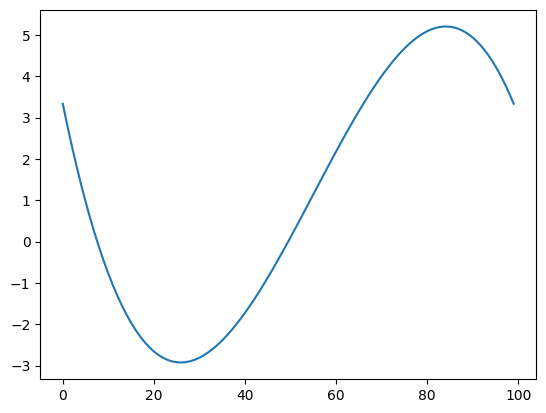

In [3]:
# make an interesting function of 100 values

x = np.linspace(-10, 10, num=100)  # x values
y = x + (x ** 2 / 30) - (x ** 3 / 100)

plt.plot(range(100), y)
plt.show()

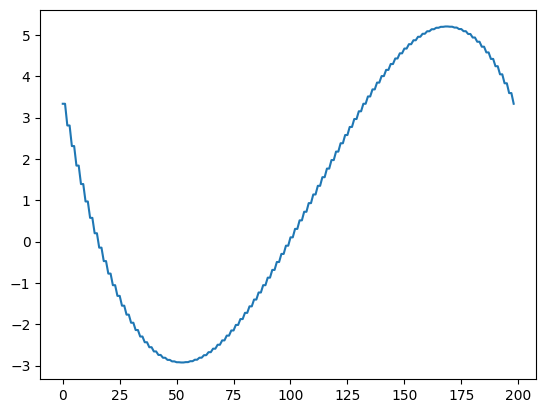

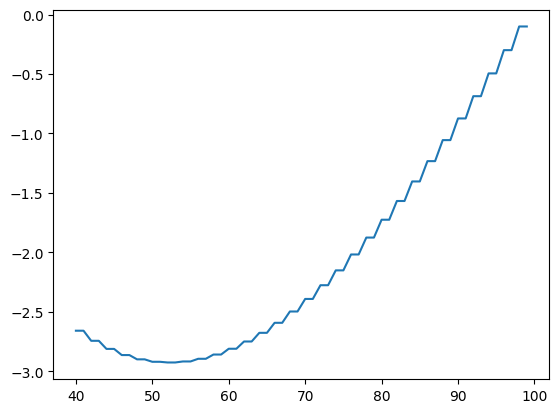

In [4]:
# up_sample y = f(x) by a factor of 2 with nearest-neighbour interpolation
# FIXED: The original code was wrong, which used `2 * (len(y) - 1)`.
# The reason we use `2 * len(y) - 1` is because:
# the original array has len(y) points, when we up-sample by a factor of 2, we want to
# insert one new point between each original point. 
# And There are len(y) - 1 gaps between the original points. 
# So, the total number of points in the up-sampled array should be `len(y)` original points
# plus `len(y) - 1` new points, which equals `2 * len(y) - 1`.
y2_nn = np.zeros(2 * len(y) - 1)

for i in range(len(y2_nn)):
    y2_nn[i] = y[i // 2]

plt.plot(range(len(y2_nn)), y2_nn)
plt.show()

# zoom into range 40:100
plt.plot(range(40, 100), y2_nn[40:100])
plt.show()

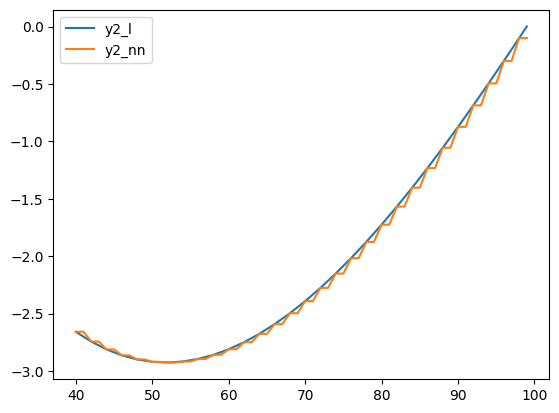

In [5]:
# FIXED: see last section description.
y2_l = np.zeros(2 * len(y) - 1)

for i in range(len(y2_l) - 1):
    # find value between int(x) and int(x)+1 at x
    y2_l[i] = linear_interpolate_of(i / 2.0, func=y)  # linear interpolation

# compare y2_l with y2_nn
plt.plot(range(40, 100), y2_l[40:100], label="y2_l")
plt.plot(range(40, 100), y2_nn[40:100], label="y2_nn")
plt.legend(loc='best')
plt.show()

## Nearest-Neighbour and Bi-Linear Interpolation of Images

With images, to upsample them, we can use nearest neighbour (NN) or bilinear interpolation. 

To upsample using NN, we just need to index to the pixel at the integer position by dividing by the upscaling
    factor, e.g. if the factor is 2, `upsampled[i, j] = original[i//2,j//2]`.
    
Bilinear interpolation take the for 'corner' pixel position values and does linear interpolation
    along the rows (or columns), and then linear along the output of the row (or column) interpolations.
    
$
    a = floor(y)\\   
    b = a + 1
    f[x, y] = linear(linear(f[a], x), linear(f[b], x), y)
$

We can write this in Python like this:
~~~~   
    def bilinear(f, x, y): # f is a 2D array   
        a = int(np.floor(y))  
        
        fa = interp(f[a,:], x)
        fb = interp(f[a+1,:], x)
        
        dy = y - a
        return fa + dy * (fb - fa)
~~~~    

## Exercise 1

1. Using the definitions of `bilinear` and `linear` define a function `upsample`. 
   
   Hint: To do this you will have to iterate over the pixel positions of the output image (upsampled) and find the floating point coordinate (x, y) in the input image and use the bilinear function to calculate the interpolated value.
~~~~
    def upsample(im, factor=2): 
    
        upsampled = np.zeros( factor*(im.shape - np.array([1, 1])) )
        
        for i in range(factor*(im.shape[0] - 1)):
            for j in range(factor*(im.shape[1] - 1)):
            
                x = i/factor
                y = j/factor
                
                upsampled[i, j] = bilinear(im, x, y)
                
        return upsampled
~~~~
2. Test your funciton on a 64 x 64 block from the `testimage512.gif` FM test pattern by a factor of 2, 3 and 4.

   Note: You will have to call this funcition with the input image as `float` types, i.e.
~~~~
    
    im2 = upsampled(im.astype('float'), factor=2)
~~~~
 
3. Compare the results with nearest-neighbour upsampling of the same block



In [6]:
def calculate_bilinear_interpolate_value_in_image(
        image: np.ndarray,
        /,
        *,
        x_of_interpolate_point: np.number,
        y_of_interpolate_point: np.number,
) -> np.float64:
    """
    Bilinear interpolation of a 2D numpy array (image) at a point (x, y).
    This function takes a non-integer location (x, y) and interpolates the
    pixel value at this point based on the surrounding pixel values.

    Args:
        image: 2D numpy array representing an image
        x_of_interpolate_point: x-coordinate (horizontal axis) to interpolate at
        y_of_interpolate_point: y-coordinate (vertical axis) to interpolate at

    Returns:
        interpolated_value: interpolated pixel value at (x, y)

    Raises:
        ValueError: if x and/or y coordinates are out of bounds of the image array
    """
    # Check if the given image is a 2D numpy array
    if image.ndim != 2:
        raise ValueError(
            f"image must be a 2D numpy array, which has {image.ndim} dimensions."
        )

    # Check if the coordinates are within the bounds of the image dimensions
    if (
            not (0 <= x_of_interpolate_point < image.shape[1]) or
            not (0 <= y_of_interpolate_point < image.shape[0])
    ):
        raise ValueError("x and/or y coordinates are out of bounds.")

    # Floor function identifies the top-left corner pixel of the 2x2 pixel square.
    x1, y1 = int(np.floor(x_of_interpolate_point)), int(np.floor(y_of_interpolate_point))

    # To get the bottom-right corner pixel, we add 1 to both coordinates.
    # We use min to prevent going out of bounds of the image.
    x2, y2 = min(x1 + 1, image.shape[1] - 1), min(y1 + 1, image.shape[0] - 1)

    # Calculate the distances (dx, dy) from the top-left pixel to the interpolation point.
    # These distances are used as weights during the interpolation.
    dx = x_of_interpolate_point - x1
    dy = y_of_interpolate_point - y1

    # Interpolate the pixel value horizontally between the top two pixels.
    # This gives us the interpolated top edge value.
    top_edge_value = (1 - dx) * image[y1, x1] + dx * image[y1, x2]

    # Interpolate the pixel value horizontally between the bottom two pixels.
    # This gives us the interpolated bottom edge value.
    bottom_edge_value = (1 - dx) * image[y2, x1] + dx * image[y2, x2]

    # Finally, interpolate vertically between the top and bottom edge values
    # using the vertical distance dy as the weight.
    interpolated_value = (1 - dy) * top_edge_value + dy * bottom_edge_value

    return interpolated_value

In [7]:
def up_sample_2d_image(image: np.ndarray, /, *, factor: int = 2) -> np.ndarray:
    if image.ndim != 2:
        raise ValueError(
            f"image must be a 2D numpy array, which has {image.ndim} dimensions."
        )

    # The 2D version of `2 * length - 1`, where 2 is an example of up-sampling factor.
    scaled = np.zeros(factor * np.array(image.shape) - np.array([1, 1]))

    for y_ in range(scaled.shape[0] - 1):
        for x_ in range(scaled.shape[1] - 1):
            scaled[y_, x_] = calculate_bilinear_interpolate_value_in_image(
                image,
                x_of_interpolate_point=x_ / factor,
                y_of_interpolate_point=y_ / factor,
            )

    return scaled

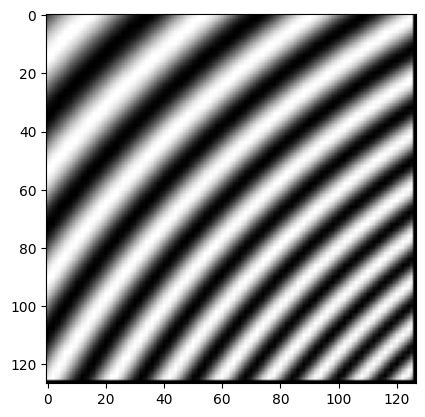

In [8]:
im = agent.get_img_located_at("testimage512.gif")

part_of_im = im[100:164, 100:164]

up_sampled = up_sample_2d_image(part_of_im.astype(np.float64), factor=2)

plt.imshow(up_sampled, cmap="grey")
plt.show()

# Image Binarization and Operations on Binary Images

The next set of experiements and exercises will be done on the `chromosomes.png` image.

We will start by binarising the image,ascii which means mapping the image pixel values to either 1 or 0 (or `True` and `False`). Normally, we want the pixels labelled 1 to be that of objects of interest, and those labelled 0 to be background. 
 
### How to threshold values in an array

Given a Numpy array, `a`, we can threshold it like this:
~~~~
    idx = (a > threshold)  # indices of values greater than threshold value

    a[idx] = 1 # set values at indices to 1
    a[~idx] = 0 # set values below threshold to 0
~~~~

Look at and run the code below to try to understand this concept of selecting index-sets
from arrays. It is a really useful and efficient way to do perform image masking and other 
manipulations (as we will see!)

In [9]:
# Try the following...

# random array of numbers
a = np.random.randint(100, size=(5, 5))
print(a)

# array of booleans where number is > 50
idx = a > 50
print(idx)

# threshold array
b = np.zeros(a.shape, dtype=np.uint8)

# do the thresholding
b[idx] = 1
b[~idx] = 0  # the ~ symbols is the NOT boolean operator

print(b)

[[25 46 68 65 55]
 [17 95 95 54  1]
 [53 76 47 57 65]
 [21 49 19 46 41]
 [67 63  1 75 33]]
[[False False  True  True  True]
 [False  True  True  True False]
 [ True  True False  True  True]
 [False False False False False]
 [ True  True False  True False]]
[[0 0 1 1 1]
 [0 1 1 1 0]
 [1 1 0 1 1]
 [0 0 0 0 0]
 [1 1 0 1 0]]


### Binarization of `chromosomes.png` image

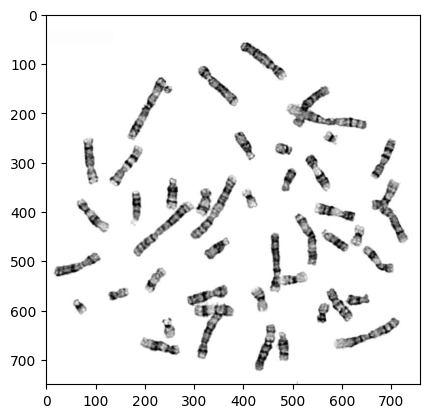

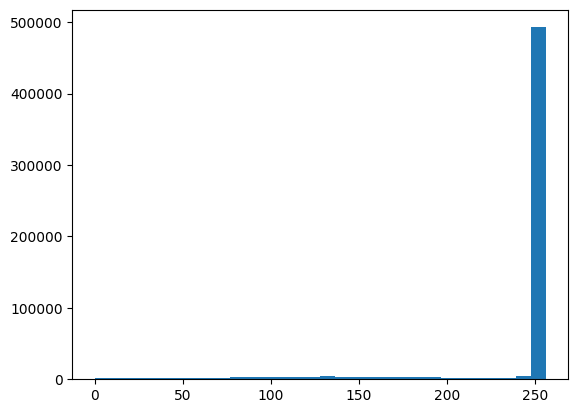

In [10]:
# read the image as a grayscale (1 channel)
chromo = agent.get_img_located_at("chromosomes.png", channel_mode="L")

plt.imshow(chromo, cmap="gray")
plt.show()

# we can use the numpy histogram function to find out the range of values in the image
plt.hist(chromo.ravel(), bins=30, range=(0, 256))  # ravel() is like flatten()
plt.show()

## Exercise 2

1. Use the array thresholding method described above to threshold the `chromo` image to 
roughly separate out the chromosomes from the background.

2. What proportion of pixels are chromosome and what are background in this image?

   Hint: You can count non-zero values in arrays using `numpy.count_nonzero()` or `np.sum()`. To count the number times
   a particular `value` is present in an array, you can use `numpy.count_nonzero(a==value)`, e.g.
~~~~
    # count number of 1s in an array a
    
    number_of_ones = np.count_nonzero(a==1)
~~~~
        
3. What does the histogram tell us about a good choice of threshold to binarise the image?

proportion of chromosome: 13.80580474934037
proportion of chromosome: 86.19419525065963


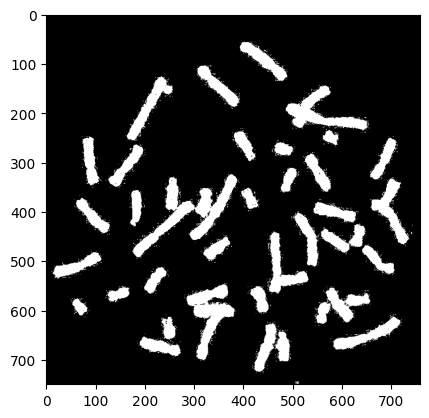

In [11]:
separated = np.where(chromo < 250, 1, 0)
plt.imshow(separated, cmap="grey")

total_chromo_pixels = np.size(chromo)
chromo_percent = np.count_nonzero(separated) / total_chromo_pixels * 100
chromo_bg_percent = 100 - chromo_percent

print(f"proportion of chromosome: {chromo_percent}")
print(f"proportion of chromosome: {chromo_bg_percent}")

# Connected components, Centroids and Principal Axes

We can use the `skiimage.measure` method to do connected component labelling, e.g.
    
~~~~
    comps = measure.label(threshed, background=0)
~~~~

Look at the following code and its output.

unique labels in comps are  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]


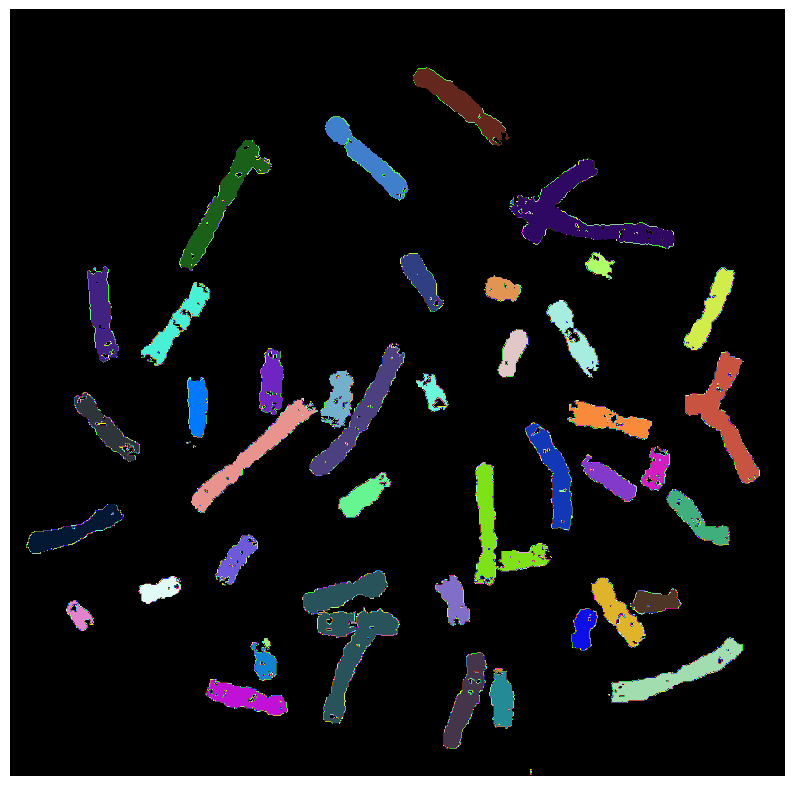

In [12]:
# Connected components, Centroids and Principal Axes
import matplotlib as mpl
from skimage import measure

# threshold at 200
threshed = np.zeros(chromo.shape, "int")
threshed[chromo < 200] = 1

# need to delete smallest component if more than 2
comps = measure.label(threshed, background=0)
print("unique labels in comps are ", np.unique(comps))

# make a colour map of random colors
rand_colors = np.random.rand(256, 3)
rand_colors[0, :] = 0.0  # black at zero index
rand_cmap = mpl.colors.ListedColormap(rand_colors)

# print(rand_colors)
fig = plt.figure(figsize=(10, 10))
plt.imshow(comps, cmap=rand_cmap)
plt.axis("off")
plt.show()

# Statistics of binarised images

We will now go on to

1. Extract out each of the components by finding its bounding box

2. Find the centroid 

3. Find its principal axis

To do all of these this, it is useful use the `numpy.mesgrid` methods which generates an array of coordinate
positions (acording to an input range of values). 

We can select a subset of these coordinates at the non-zero pixel positions of a binary image and then
find out the minimum and maximum values of these selected coordintes. 

Look at the `bounding_box` method below and try to work out how it is able to find the 
minimum and maximum extents of a given connected component in the original image.

We will see that the same approach will allow us to find the centroids and principal axes of the 
component.

In [13]:
# find the coordinate bounding box of a given label in a components image
def bounding_box(comps, label=1):
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0, comps.shape[1]), np.arange(0, comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps == label]
    where_y = yy[comps == label]

    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

label  0  has bounding box  (0, 0, 757, 749) , component size is  505935


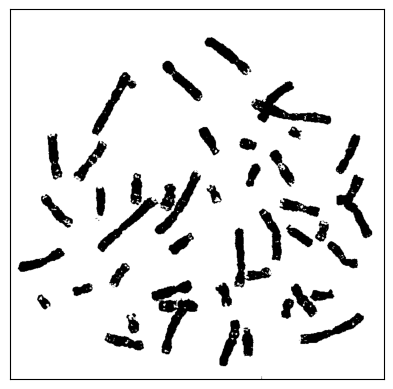

label  1  has bounding box  (394, 57, 488, 133) , component size is  1995


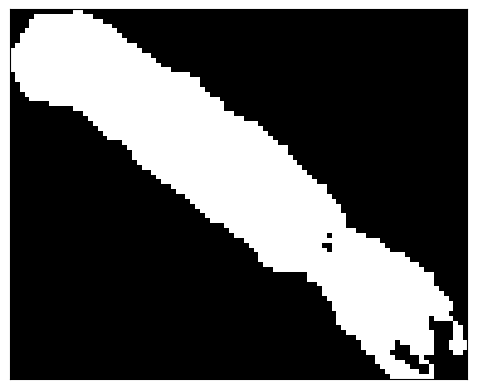

label  2  has bounding box  (308, 105, 389, 186) , component size is  1868


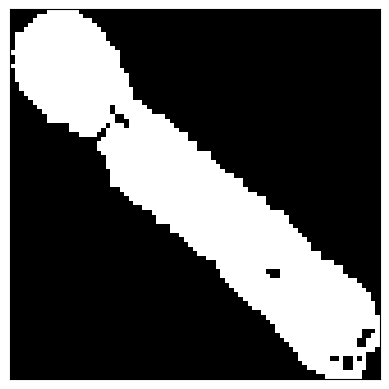

label  3  has bounding box  (166, 128, 255, 255) , component size is  2582


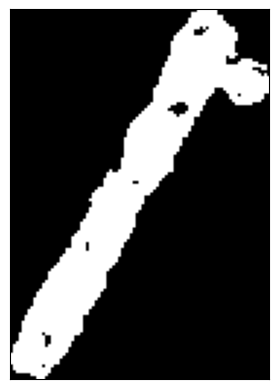

label  4  has bounding box  (488, 146, 649, 233) , component size is  4259


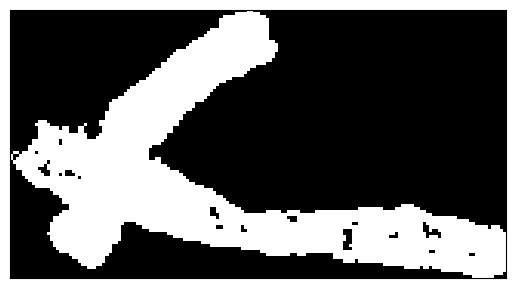

label  5  has bounding box  (492, 184, 492, 184) , component size is  0
label  6  has bounding box  (489, 186, 492, 190) , component size is  9
label  7  has bounding box  (563, 238, 590, 262) , component size is  378


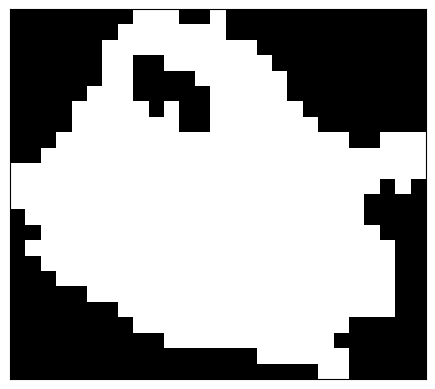

label  8  has bounding box  (382, 239, 423, 295) , component size is  1045


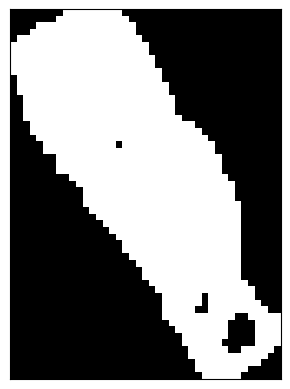

label  9  has bounding box  (76, 252, 105, 345) , component size is  1538


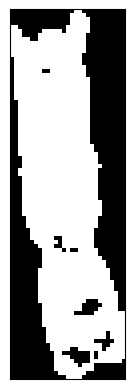

label  10  has bounding box  (81, 253, 83, 255) , component size is  2
label  11  has bounding box  (659, 253, 708, 333) , component size is  1405


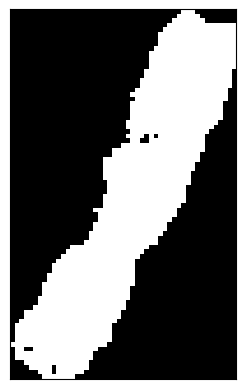

label  12  has bounding box  (464, 261, 499, 285) , component size is  613


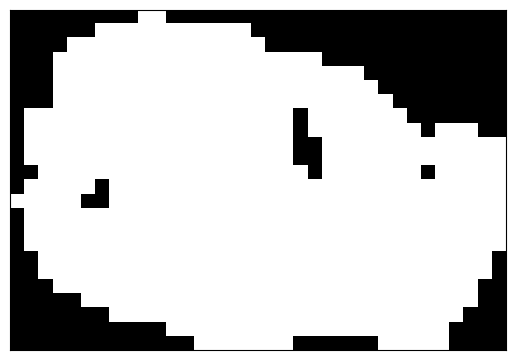

label  13  has bounding box  (585, 261, 587, 264) , component size is  3
label  14  has bounding box  (129, 267, 195, 348) , component size is  1464


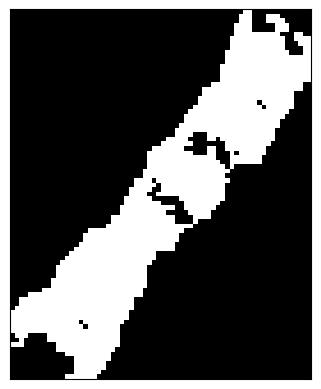

label  15  has bounding box  (525, 285, 575, 359) , component size is  1277


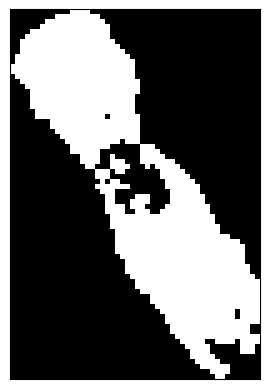

label  16  has bounding box  (477, 313, 506, 359) , component size is  768


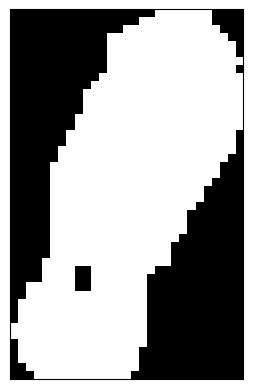

label  17  has bounding box  (293, 327, 385, 455) , component size is  2572


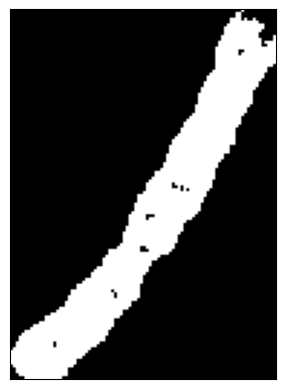

label  18  has bounding box  (377, 327, 377, 327) , component size is  0
label  19  has bounding box  (379, 328, 379, 328) , component size is  0
label  20  has bounding box  (244, 332, 267, 396) , component size is  1084


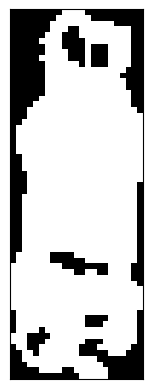

label  21  has bounding box  (661, 335, 732, 463) , component size is  2815


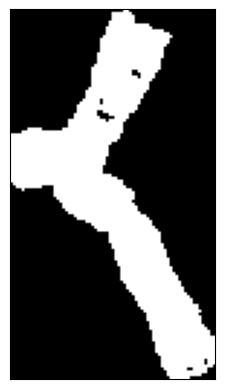

label  22  has bounding box  (134, 342, 138, 344) , component size is  4
label  23  has bounding box  (303, 353, 335, 409) , component size is  1062


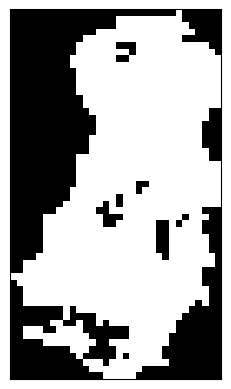

label  24  has bounding box  (398, 356, 428, 393) , component size is  509


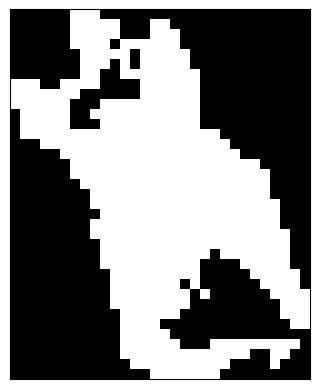

label  25  has bounding box  (569, 359, 569, 359) , component size is  0
label  26  has bounding box  (174, 360, 192, 418) , component size is  878


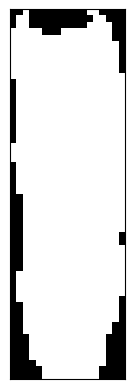

label  27  has bounding box  (63, 375, 126, 442) , component size is  1318


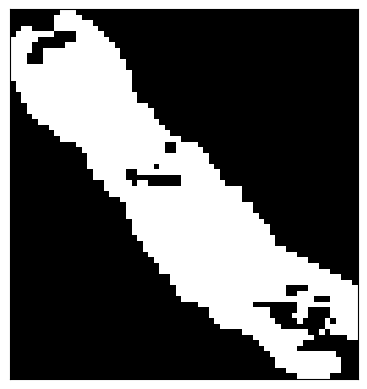

label  28  has bounding box  (177, 381, 300, 491) , component size is  2513


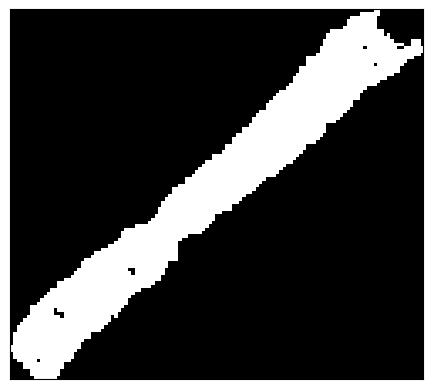

label  29  has bounding box  (545, 383, 626, 420) , component size is  1377


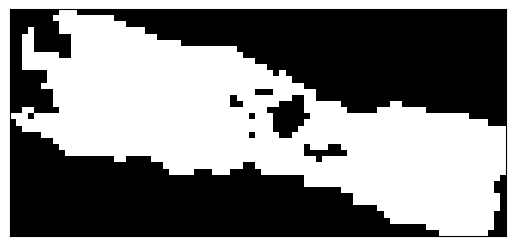

label  30  has bounding box  (291, 384, 296, 388) , component size is  10
label  31  has bounding box  (305, 399, 306, 399) , component size is  0
label  32  has bounding box  (504, 404, 549, 509) , component size is  1846


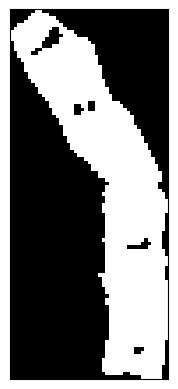

label  33  has bounding box  (173, 423, 176, 424) , component size is  1
label  34  has bounding box  (179, 427, 180, 428) , component size is  1
label  35  has bounding box  (633, 428, 642, 433) , component size is  14
label  36  has bounding box  (617, 429, 644, 470) , component size is  603


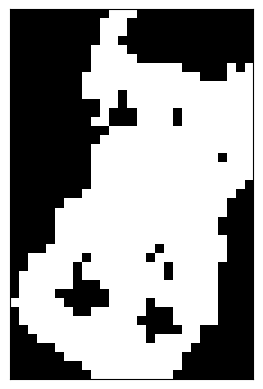

label  37  has bounding box  (559, 436, 612, 481) , component size is  980


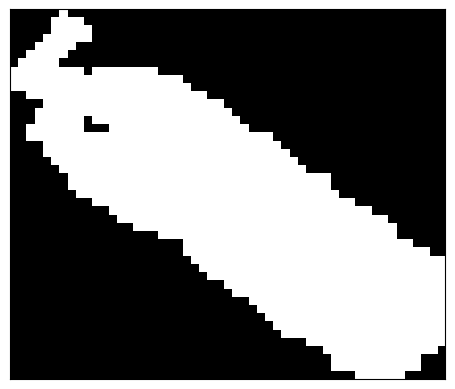

label  38  has bounding box  (454, 443, 528, 563) , component size is  2676


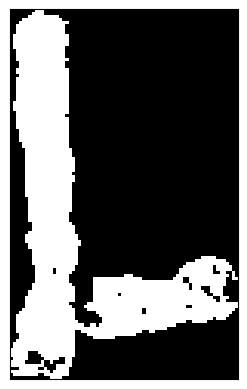

label  39  has bounding box  (321, 453, 371, 496) , component size is  996


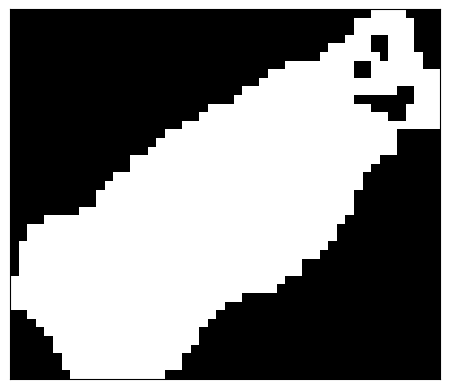

label  40  has bounding box  (642, 470, 703, 524) , component size is  1176


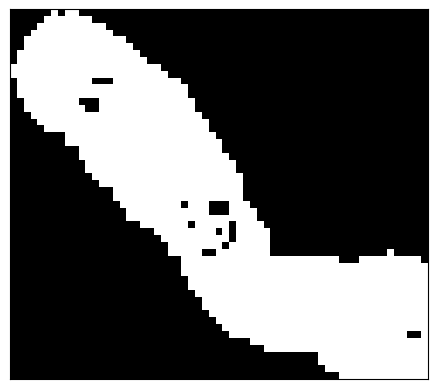

label  41  has bounding box  (16, 484, 110, 531) , component size is  1661


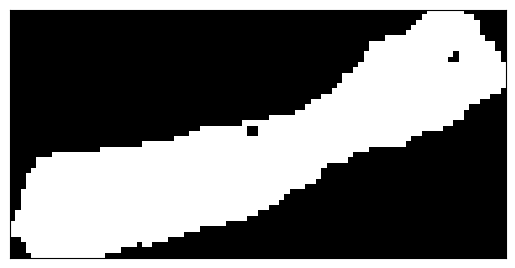

label  42  has bounding box  (201, 514, 241, 562) , component size is  840


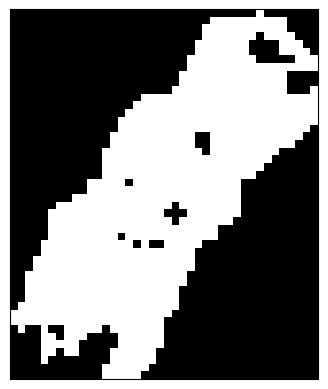

label  43  has bounding box  (529, 535, 529, 535) , component size is  0
label  44  has bounding box  (286, 549, 380, 698) , component size is  4804


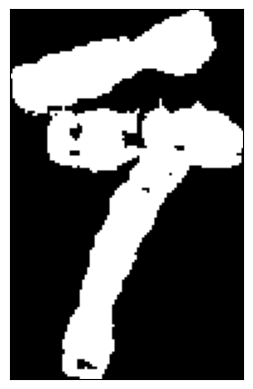

label  45  has bounding box  (416, 554, 448, 602) , component size is  873


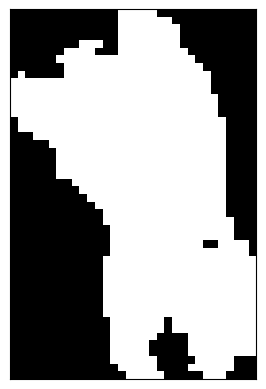

label  46  has bounding box  (126, 555, 166, 580) , component size is  633


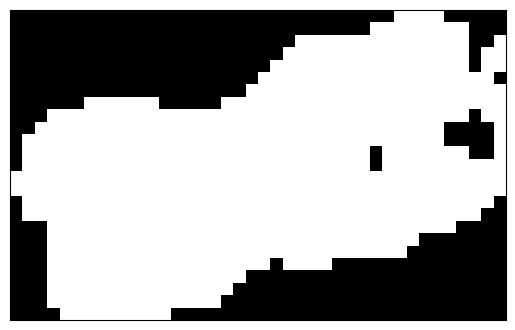

label  47  has bounding box  (569, 556, 621, 623) , component size is  1401


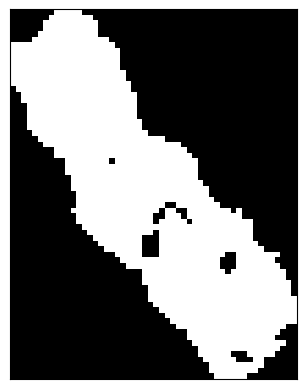

label  48  has bounding box  (202, 557, 202, 557) , component size is  0
label  49  has bounding box  (211, 560, 211, 560) , component size is  0
label  50  has bounding box  (208, 562, 208, 562) , component size is  0
label  51  has bounding box  (210, 563, 210, 563) , component size is  0
label  52  has bounding box  (607, 567, 656, 591) , component size is  779


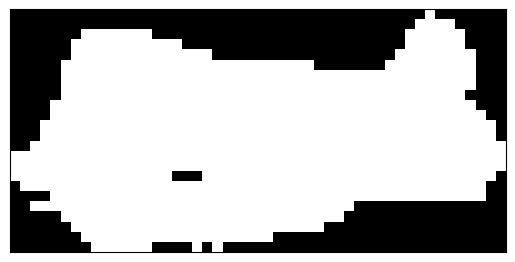

label  53  has bounding box  (55, 578, 81, 607) , component size is  399


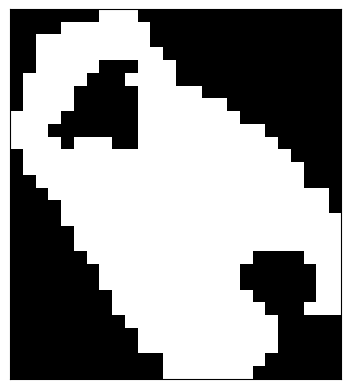

label  54  has bounding box  (549, 586, 574, 626) , component size is  690


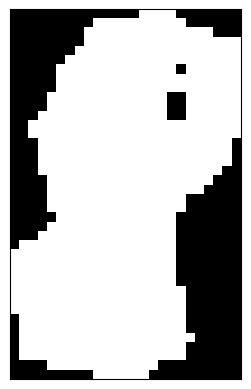

label  55  has bounding box  (334, 600, 337, 600) , component size is  0
label  56  has bounding box  (620, 615, 620, 615) , component size is  0
label  57  has bounding box  (588, 615, 715, 677) , component size is  2254


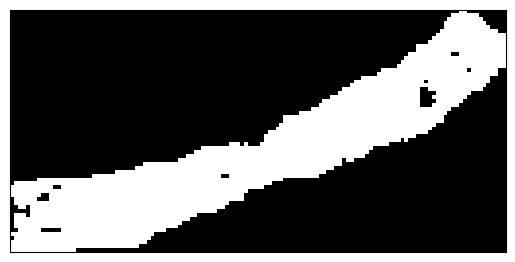

label  58  has bounding box  (247, 616, 254, 623) , component size is  37
label  59  has bounding box  (235, 619, 261, 656) , component size is  551


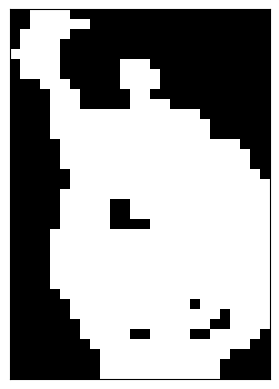

label  60  has bounding box  (252, 625, 253, 625) , component size is  0
label  61  has bounding box  (424, 629, 465, 722) , component size is  1695


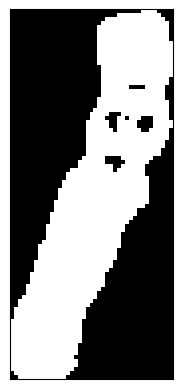

label  62  has bounding box  (473, 645, 481, 648) , component size is  21
label  63  has bounding box  (469, 648, 492, 703) , component size is  967


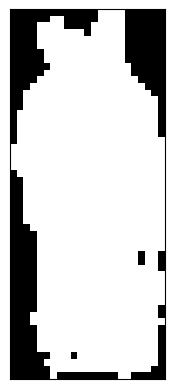

label  64  has bounding box  (191, 656, 270, 690) , component size is  1404


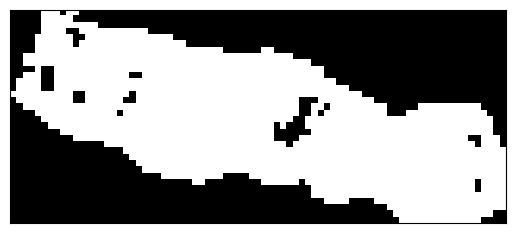

label  65  has bounding box  (585, 670, 585, 670) , component size is  0
label  66  has bounding box  (509, 744, 509, 745) , component size is  0
label  67  has bounding box  (509, 747, 509, 748) , component size is  0


In [14]:
# the following code finds the bounding boxes of each component and
# then creates a subimage (one_comp), and stores this in a list

# the code also discards any small components (less than min_size in size)

unique = np.unique(comps)  # unique labels

min_size = 100

bounding_boxes = []
component_images = []  # list of component images
for l in unique:
    bb = bounding_box(comps, label=l)

    # make a binary image for each component
    one_comp = np.zeros(comps.shape, dtype="uint8")
    one_comp[comps == l] = 1

    one_comp = one_comp[bb[1]: bb[3], bb[0]: bb[2]]

    # measure its size
    n = np.count_nonzero(one_comp)

    print("label ", l, " has bounding box ", bb, ", component size is ", n)

    # plot as image if it's big enough
    if n > min_size:
        bounding_boxes.append(bb)
        component_images.append(one_comp)  # keep it as we can use do more stuff on it

        plt.imshow(one_comp, cmap="gray")
        plt.xticks([])
        plt.yticks([])

        plt.show()

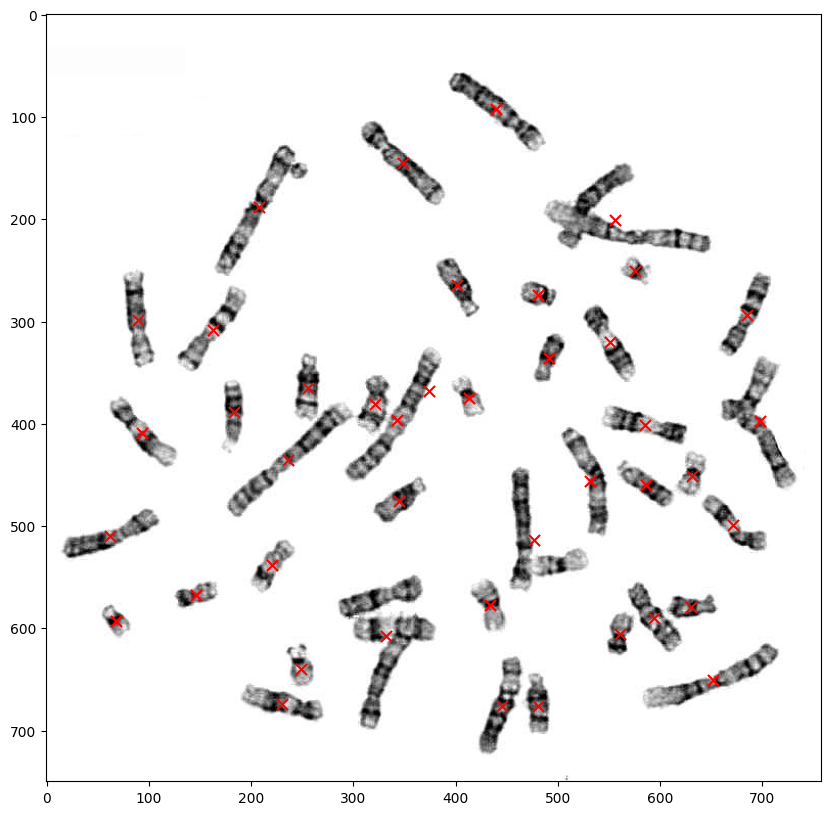

In [15]:
# Finding the binary image centroid


# calculate and plot principal axis of a binarised object
def centroid(im):
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0, im.shape[1]), np.arange(0, im.shape[0]))

    # mask by where im is non-zero
    x = xx[im != 0]
    y = yy[im != 0]

    # return the mean of the coordinates of the component
    return np.array([np.mean(x), np.mean(y)])


# test out the centroid function
fig = plt.figure(figsize=(10, 10))
plt.imshow(chromo, cmap="gray")

# overlay the centroid positions of each connected component
for i in range(len(component_images)):
    bb = bounding_boxes[i]
    pos = centroid(component_images[i])

    # plt.scatter is useful to plot points as a given marker on an image
    plt.scatter((bb[0] + pos[0]), (bb[1] + pos[1]), marker="x", s=64, c=[(1, 0, 0)])

plt.show()

## Principal Axes

To calculate the principal axes of a binary component, we need to find the principal eigen vector
of the covariance of the coordinates (with respect to the centroid). Mathematically, this 
is calculated by:
    
$
    C = \frac{1}{N}\sum_k  \mathbf{x}_k \mathbf{x}_k^T
$
where $ N $ is the number of pixels and $ \mathbf{x} $ is the coordinate of the pixel. $ C $ is the 
covariance matrix which then needs to be decomponsed into eigen values and eigen vectors
$
    C \mathbf{v}_j = \lambda_j \mathbf{v}_j
$
Since $ C $ is a 2 x 2 matrix, there are two eigen values and two eigen vectors. 

The principal axis $ \mathbf{p} $ is the eigen vector assocated with the largest eigen value.

To implement this, I have written a function `principal_axes`. Try to understand what it does.




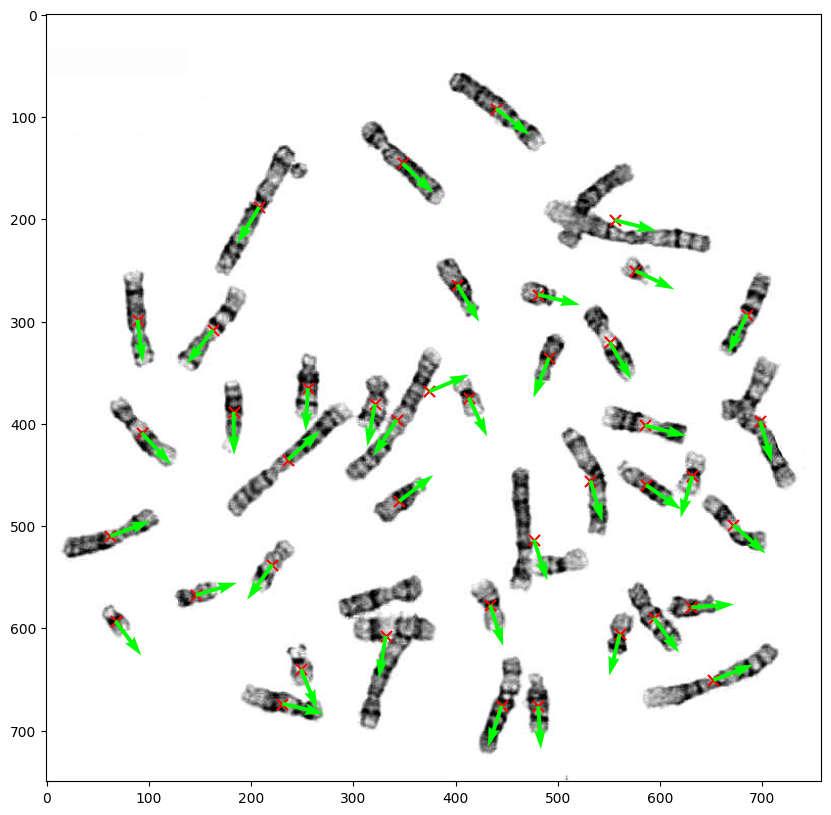

In [16]:
def principal_axes(im):
    m = centroid(im)

    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0, im.shape[1]), np.arange(0, im.shape[0]))

    # mask by where value is given label and subtract mean positions
    x = xx[im != 0] - m[0]
    y = yy[im != 0] - m[1]

    # print(x.shape)
    # print(y.shape)

    # stack all the x and y coordinates into a single two-row matrix (2, N)
    xy = np.vstack((x, y))

    # do outer-product matrix - results in a 2x2 matrix
    xy2 = np.matmul(xy, np.transpose(xy))

    # find principal eigen vector
    eval, evec = np.linalg.eig(xy2)

    # print(eval, evec)
    # print(xy2.shape)
    # get the vector associated with largest eigen value
    p_axes = np.identity(2)
    if eval[0] > eval[1]:
        p_axes = evec[0, :]
    else:
        p_axes = evec[1, :]

    return p_axes


# test out the principal axes code
fig = plt.figure(figsize=(10, 10))
plt.imshow(chromo, cmap="gray")

# overlay centroid and principal axis (as arrow) on top of image
for i in range(len(component_images)):
    bb = bounding_boxes[i]

    pos = centroid(component_images[i])
    axes = principal_axes(component_images[i])

    plt.scatter((bb[0] + pos[0]), (bb[1] + pos[1]), marker="x", s=64, c=[(1, 0, 0)])
    plt.quiver(
        bb[0] + pos[0], bb[1] + pos[1], axes[0], axes[1], width=0.005, color=(0, 1, 0)
    )

plt.show()

## Exercise 3

Select an image of your own which can be easily binarised into an foreground and a background.

1. Perform the operation of binarisation (perhaps by looking at the histogram of the image first)

2. Find the connected components in the image and extract them out as separate images.

3. Plot the centroids and principal axes on your binarised image

4. Make a table of showing the component, its size, its centroid position and the angle of its principal axis


## Distance transforms and Skeletons

Binarised data can be represented by its skelton and we can also calculate what is called a *distance transform*
where each pixel in the image is given a distance to the closest object boundary (either internal to the object,
or external of the object).

The `scipy.ndimage.morphology` module has methods to calculate distance transforms of binarised images. Like the following.

### Exercise 4

1. What could you use distannce transforms and skeletons for?


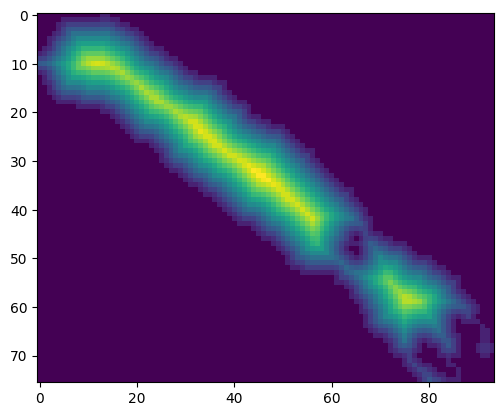

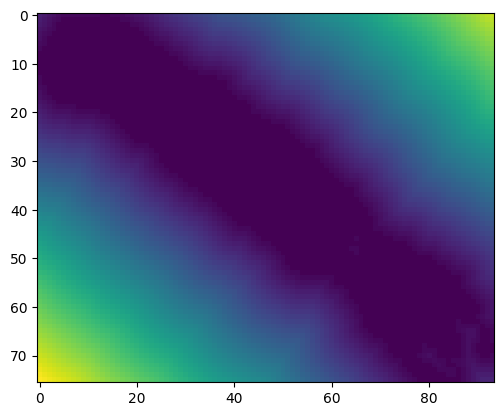

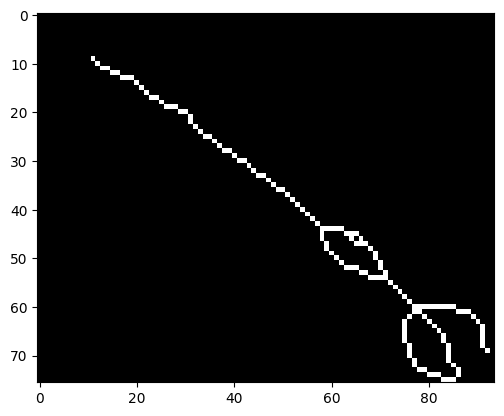

In [17]:
# Distance transforms and Skeletons
# Skimage skeletons
import scipy.ndimage as morpho
import skimage.morphology as sci_morpho

dt = morpho.distance_transform_edt(component_images[1])
dt_not = morpho.distance_transform_edt(~(component_images[1].astype("bool")))

plt.imshow(dt)
plt.show()

plt.imshow(dt_not)
plt.show()

skel = sci_morpho.skeletonize(component_images[1])
plt.imshow(skel, cmap="gray")
plt.show()

## Run-length encoding and Chain Codes

Run-length encoding takes a binarised image and sweeps across the image, pixel-by-pixel, row-by-row counting
the numbers of consecutive 1's and 0's encountered. The output is the number of pixels which were 1 (or 0) in any 
given run or sequence. 

Chain codes are generated by starting at a boundary pixel of a binary image and walking around the edge outputing
one of 8 directions, encoded as 0..8 for the 8 directions you can go from boundary pixel to boundary pixel.


## Exercise 5

1. Write a function to convert a binary image to a run-length encoded output. 
You can output the image dimensions, the initial state (1 or 0) and then a sequence of integers for the run-lengths.

Hint: It will help to flatten the input image using `numpy.ravel()` when finding the runs.

2. Write a funciton to take your run-length encoded image and reconstruct it.

Hint: Store the output of your answer to (1) as a list of integers and pass this as input to your decoder, which should return a binary image. You can make a 1D array of the image and then reshape it using `numpy.reshape()` to be rectangular.

3. Test your function on the chromosomes components generated in this lab. How does the run-length encoding compare in size to the original image (if you assume that each integer can be encoded as 8 bits).

4. Write a function to generate chain codes from a binary image and test it on the chromosomes components images.

